<a href="https://colab.research.google.com/github/gustavolio/Privacy_Preserving_Heterogeneous_Network_Embedding/blob/main/PHINE_with_synthea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PHINE: Privacy Heterogeous Network Embeddings**

This is an approach to generate privacy-preserving heterogeneous network embeddings on clinical events reccorded on Electronic healthcare Records (EHR). We explore Graph Autoencoders (GAE) with an objective function that simultaneously maximizes the embeddings' usefulness for classification tasks (i.e., preserving HIN properties and topology) and minimizes the effectiveness of inference attacks from embedding (i.e., hiding private information).

## Download and unzip data

In [ ]:
!wget https://storage.googleapis.com/synthea-public/synthea_sample_data_csv_apr2020.zip
!unzip synthea_sample_data_csv_apr2020
!mv csv/* .

In [ ]:
#Remove unnecessary files
!rm -r /content/payers.csv
!rm -r /content/providers.csv
!rm -r /content/organizations.csv
!rm -r /content/supplies.csv
!rm -r /content/payer_transitions.csv

## Read csv files

In [ ]:
#Read files and create and array with all of them
import numpy as np
import pandas as pd
import glob
import networkx as nx
import matplotlib.pyplot as plt
import re
import datetime
from dateutil.relativedelta import relativedelta

#Read all csv files
def read_csv(file_names, path):
    data = []

    for filename in file_names:
        file_path = path + filename;
        df = pd.read_csv(file_path, header=0)
        #dropnan
        data.append(df)

    return data

df_file_names = glob.glob("*.csv")
syn_data = read_csv(df_file_names, '/content/')

In [ ]:
def set_node_type(file_name, df):
    #get node type
    node_type = re.split("[.]", file_name)[0]
    #get number rows
    number_rows = df.shape[0]
    #create a new column with node type
    df['node_type'] = np.full(number_rows, node_type)

#Put node_type columns
for index,df in enumerate(syn_data):
    #get file name
    file_name = df_file_names[index]
    set_node_type(file_name, df)

['observations']
['encounters']
['medications']
['immunizations']
['imaging_studies']
['careplans']
['devices']
['patients']
['conditions']
['procedures']
['allergies']


## Create Network

In [ ]:
# child =< 12
# 12 < young < 18
# 18 <= adult < 60
# 60 <= elderly
def set_age_cat(birthdate, deathdate):
    category = ''
    age = 0
    final_date = datetime.datetime.now()
    birth = datetime.datetime(int(birthdate[0:4]),int(birthdate[5:7]),int(birthdate[8:]))

    if not(pd.isnull(deathdate)):
        final_date = datetime.datetime(int(deathdate[0:4]),int(deathdate[5:7]),int(deathdate[8:]))

    age = relativedelta(final_date, birth).years
    if (age <= 12):
        category = 'child'
    elif (12 < age < 18):
        category = 'young'
    elif (18 <= age < 60):
        category = 'adult'
    else:
        category = 'eaderly'

    return category

#Add generic nodes
def add_syn_node(graph, df):
    for index,n_data in df.iterrows():
        graph.add_node(n_data['DESCRIPTION'], node_type=n_data['node_type'])
        graph.add_edge(n_data['PATIENT'], n_data['DESCRIPTION'])

#Add imaging_studies nodes
def add_syn_node_img(graph, df):
    for index,n_data in df.iterrows():
        graph.add_node(n_data['BODYSITE_DESCRIPTION'], node_type=n_data['node_type'])
        graph.add_edge(n_data['PATIENT'], n_data['BODYSITE_DESCRIPTION'])

#Add patients node nodes
def add_syn_node_pat(graph, df):
    for index,n_data in df.iterrows():
        age_cat = set_age_cat(n_data['BIRTHDATE'], n_data['DEATHDATE'])

        graph.add_node(n_data['Id'],
                       node_type=n_data['node_type'],ethnicity=n_data['ETHNICITY'],
                       birth=n_data['BIRTHDATE'], death=n_data['DEATHDATE'],
                       gender=n_data['GENDER'], age_category=age_cat,
                       marital=n_data['MARITAL'], race=n_data['RACE'],
                       city=n_data['CITY'])


G = nx.Graph()
#Create a heterogeneous network
for index,df in enumerate(syn_data):
    node_type = df[:1]['node_type'].values[0]

    if node_type == 'patients':
        add_syn_node_pat(G, df)
    elif node_type == 'imaging_studies':
        add_syn_node_img(G, df)
    else:
        add_syn_node(G, df)
    
    print('{}/{} -- {}'.format(index, len(syn_data), node_type))

In [ ]:
# Number of nodes
print("Number of Node: {} \nNumber of Edges: {}".format(len(G), G.number_of_edges()))

Number of Node: 1834 
Number of Edges: 78055


# Heterogeneous Network Regularization

In [ ]:
!pip install git+https://github.com/rmarcacini/sentence-transformers
!pip install gdown
!gdown https://drive.google.com/uc?id=1NV5t1YhyyOzMF5zAovfbSLdZZLvqrfZ_
!unzip distiluse-base-multilingual-cased.zip -d language_model
from sentence_transformers import SentenceTransformer, LoggingHandler
import numpy as np
import logging

np.set_printoptions(threshold=100)
logging.basicConfig(format='%(asctime)s - %(message)s',datefmt='%Y-%m-%d %H:%M:%S',level=logging.INFO,handlers=[LoggingHandler()])

language_model = SentenceTransformer('./language_model')

In [ ]:
## Add y attr at node. y represents a embedding.
from tqdm.notebook import tqdm
counter = 0
cache_embedding = {}
for node in tqdm(G.nodes()):
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']!='patients':
    embedding = None
    if node not in cache_embedding:
      embedding = language_model.encode(node,show_progress_bar=False)
      cache_embedding[node]=embedding
    else:
      embedding = cache_embedding[node]
    G.nodes[node]['y'] = embedding

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import random


def regularization(G, dim, iterations=15, mi=0.85):

    nodes = []

    # Init 'f' vector on all nodes
    for node in G.nodes():
        G.nodes[node]['f'] = np.array([0.0]*dim)
        if 'y' in G.nodes[node]:
            G.nodes[node]['f'] = G.nodes[node]['y']*1.0
        nodes.append(node)

    pbar = tqdm(range(0, iterations))

    for iteration in pbar:
        random.shuffle(nodes)
        energy = 0.0

        # Go through each node
        for node in nodes:
            f_new = np.array([0.0]*dim)
            f_old = np.array(G.nodes[node]['f'])*1.0
            sum_w = 0.0
            
            # Go through node neighbors
            for neighbor in G.neighbors(node):
                w = 1.0
                if 'weight' in G[node][neighbor]:
                    w = G[node][neighbor]['weight']

                w /= np.sqrt(G.degree[neighbor])

                f_new += w*G.nodes[neighbor]['f']

                sum_w += w

            if sum_w == 0: continue
            f_new /= sum_w

            G.nodes[node]['f'] = f_new*1.0

            if 'y' in G.nodes[node]:
                G.nodes[node]['f'] = G.nodes[node]['y'] * mi + G.nodes[node]['f']*(1.0-mi)

            energy += np.linalg.norm(f_new-f_old)

        iteration += 1
        message = 'Iteration '+str(iteration)+' | Energy = '+str(energy)
        pbar.set_description(message)

    return G

regularization(G,512)

# Convesions for algorithm input

In [ ]:
#Create node list 
node_list = []
for node in G.nodes():
    node_list.append(node)

#Adjacence matrix
adj_matrix = nx.adjacency_matrix(G,nodelist=node_list)

# Feature matrix
## Utility feature -> Prediabetes
utility_feature = []
utility_label = []
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':
    for node2 in G.nodes():
      if 'node_type' in G.nodes[node2] and G.nodes[node2]['node_type']=='conditions' and node2 == 'Prediabetes':
            if node in G.neighbors(node2):
              utility_feature.append([0,1,0]) # one-hot
              utility_label.append([1])
              break
            else:
              utility_feature.append([0,0,1]) # one-hot
              utility_label.append([2])
              break
  else: # If the node type isn't patient
    utility_feature.append([1,0,0]) # one-hot
    utility_label.append([0])


## Utility feature -> Otitis media
# utility_feature = []
# utility_label = []
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':
#     for node2 in G.nodes():
#       if 'node_type' in G.nodes[node2] and G.nodes[node2]['node_type']=='conditions' and node2 == 'Otitis media':
#             if node in G.neighbors(node2):
#               utility_feature.append([0,1,0]) # one-hot
#               utility_label.append([1])
#               break
#             else:
#               utility_feature.append([0,0,1]) # one-hot
#               utility_label.append([2])
#               break
#   else: # If the node type isn't patient
#     utility_feature.append([1,0,0]) # one-hot
#     utility_label.append([0])
    

In [ ]:
## Privacy feature -> Gender
privacy_feature = []
privacy_label = []
t = set()
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':      
    if G.nodes[node]['gender']=='F':
      privacy_feature.append([0,1,0]) #one-hot
      privacy_label.append([1])
    if G.nodes[node]['gender']=='M':
      privacy_feature.append([0,0,1]) #one-hot
      privacy_label.append([2])
  else: # If the node type isn't patient
    privacy_feature.append([1,0,0]) #one-hot
    privacy_label.append([0])


## Privacy feature -> Marital (status)
# privacy_feature = []
# privacy_label = []
# t = set()
# for node in node_list:
#   if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients':
#     if G.nodes[node]['marital']=='S':
#       privacy_feature.append([0,1,0,0]) #one-hot
#       privacy_label.append([1])
#     else:
#       if G.nodes[node]['marital']=='M':
#         privacy_feature.append([0,0,1,0]) #one-hot
#         privacy_label.append([2])
#       else:
#         privacy_feature.append([0,0,0,1]) #one-hot
#         privacy_label.append([3])
#   else: # If the node type isn't patient
#     privacy_feature.append([1,0,0,0]) #one-hot
#     privacy_label.append([0])

# Evaluate textual representation capacity to utility feature forecast

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier



emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(utility_feature[counter]))
    emb_patients.append(G.nodes[node]['f'])
  counter += 1


from sklearn.model_selection import cross_val_score
#clf = SVC(random_state=42)

# KNN Classifier
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

(1171, 512)
(1171,) 1 2
0.83 f-1 macro with a standard deviation of 0.03
0.87 accuracy with a standard deviation of 0.02
[dummy] 0.52 f-1 macro with a standard deviation of 0.02
[dummy] 0.60 accuracy with a standard deviation of 0.02


2021-03-03 16:25:50 - NumExpr defaulting to 2 threads.


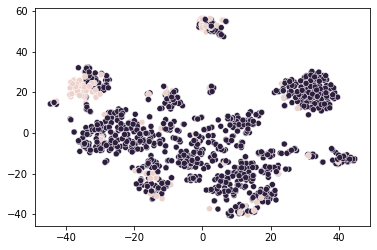

In [ ]:
import pandas as pd


import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(emb_patients)
X_embedded.shape

df = pd.DataFrame(X_embedded)
df['label'] = emb_labels
df = df.dropna()
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

g = sns.scatterplot(x=0, y=1, data=df, hue="label", legend=False)
g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('node2vec.pdf')

# Evaluate textual representation capacity to privacy feature forecast



In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(privacy_feature[counter]))
    emb_patients.append(G.nodes[node]['f'])
  counter += 1

print(np.array(emb_patients).shape)
print(np.array(emb_labels).shape,np.min(np.array(emb_labels)),np.max(np.array(emb_labels)))

from sklearn.model_selection import cross_val_score
#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

(1171, 512)
(1171,) 1 2
0.70 f-1 macro with a standard deviation of 0.02
0.70 accuracy with a standard deviation of 0.02
[dummy] 0.53 f-1 macro with a standard deviation of 0.05
[dummy] 0.51 accuracy with a standard deviation of 0.03


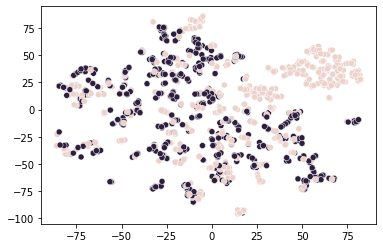

In [ ]:
import pandas as pd


import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=5).fit_transform(emb_patients)
X_embedded.shape

df = pd.DataFrame(X_embedded)
df['label'] = emb_labels
df = df.dropna()
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

g = sns.scatterplot(x=0, y=1, data=df, hue="label", legend=False)
g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('knn_hm_private.pdf')

# Generate Feature Matrix

In [ ]:
### Generating feature matrix
feature_matrix = []
for patient in node_list:
  feature_matrix.append(G.nodes[patient]['f'])

feature_matrix = np.array(feature_matrix)

## Concatenating privacy features
feature_matrix = np.concatenate((feature_matrix,np.array(privacy_feature)), axis=1)

## Generate label matrix
label_matrix = np.concatenate((np.array(utility_label),np.array(privacy_label)),axis=1)

# Privacy Network Embedding Instantiating

In [ ]:
!git clone https://github.com/KaiyangLi1992/Privacy-Preserving-Social-Network-Embedding/

In [ ]:
!mv Privacy-Preserving-Social-Network-Embedding/* .

In [ ]:
### Training

from __future__ import division
from __future__ import print_function

import sys
import pickle as pkl
import tensorflow.compat.v1 as tf
import numpy as np
import scipy.sparse as sp
from input_data import load_data
from meansuring import get_score
from preprocessing import preprocess_graph,sparse_to_tuple,construct_feed_dict
from constructor import get_placeholder, get_model, get_optimizer, update
from process_attr import get_attr_list
# Train on CPU (hide GPU) due to memory constraints
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


tf.reset_default_graph()

def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)
# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
# Settings
flags.DEFINE_string('f', '', 'Kernel')
flags.DEFINE_string('dataset', 'yale', 'Name of dateset')
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_float('discriminator_learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('hidden1', 128, 'Number of units in GCN layer 1.')
flags.DEFINE_integer('hidden3', 32, 'Number of units in discriminator layer 1.')
flags.DEFINE_integer('hidden4', 16, 'Number of units in discriminator layer 2.')
flags.DEFINE_float('dropout', 0.2, 'Dropout rate (1 - keep probability).')
flags.DEFINE_integer('epochs', 100, 'Number of iterations.')
flags.DEFINE_integer('pri_weight', 1,'weight of privacy')
flags.DEFINE_integer('uti_attr_weight', 1,'weight of utility_attr')
flags.DEFINE_integer('hidden2', 8, 'Number of units in GCN layer 2.')
flags.DEFINE_float('link_weight', 1,'weight of privacy')

# Load variables
adj = adj_matrix
adj_train = adj_matrix
features = feature_matrix
labels = label_matrix

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj = adj_train

# Some preprocessing
adj_norm = preprocess_graph(adj)
features_mat = features

y=labels[:,0]
labels

attr_labels = np.array(utility_feature)
privacy_labels = np.array(privacy_feature)

attr_labels_list = [attr_labels,privacy_labels]
dim_attr = [attr_labels.shape[1], privacy_labels.shape[1]]
features_rm_privacy = features_mat[:,:-np.array(privacy_feature).shape[1]] 

features_lil = sp.lil_matrix(features_rm_privacy)
features_tuple = sparse_to_tuple(features_lil .tocoo())

num_nodes = adj.shape[0]
features_sp = sparse_to_tuple(features_lil.tocoo())

num_features = features_sp[2][1]
features_nonzero = features_sp[1].shape[0]

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = 1

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)


#Define placeholders
placeholders = get_placeholder(adj)
d_real, discriminator, ae_model = get_model(placeholders, num_features, 
                                            num_nodes, features_nonzero,attr_labels_list[-1],dim_attr)
opt = get_optimizer(ae_model, discriminator, placeholders, pos_weight, norm, d_real, 
                            num_nodes,attr_labels_list)

#Train Model
preds_all = None
labels_all = None
epochs = 10
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):    
    emb,emb_long,avg_cost,attr_loss,pri_loss,link_loss = update(ae_model, opt, sess,adj_norm,adj_label,features_tuple, placeholders, adj)

print("Optimization Finished!")

# Evaluate Generated Embedding capacity to utility feature forecast

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier


emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(utility_feature[counter]))
    emb_patients.append(emb[counter])
  counter += 1

# KNN Classifier
from sklearn.model_selection import cross_val_score
#clf = SVC(random_state=42,class_weight={1: 4})
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))



0.72 f-1 macro with a standard deviation of 0.02
0.77 accuracy with a standard deviation of 0.02
[dummy] 0.52 f-1 macro with a standard deviation of 0.03
[dummy] 0.63 accuracy with a standard deviation of 0.03


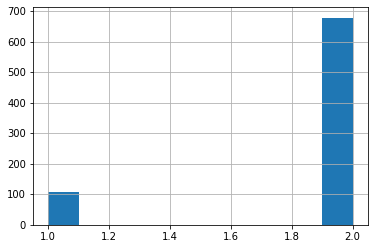

In [ ]:
pd.DataFrame(y_train)[0].hist()

# Evaluate Generated Embedding capacity to utility feature forecast

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

emb_labels = []
emb_patients = []
counter = 0
for node in node_list:
  if 'node_type' in G.nodes[node] and G.nodes[node]['node_type']=='patients': 
    emb_labels.append(np.argmax(privacy_feature[counter]))
    emb_patients.append(emb[counter])
  counter += 1


from sklearn.model_selection import cross_val_score

# KNN Classifier
#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("%0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

#clf = SVC(random_state=42)
clf = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# Dummy Classifier
dummy_clf = DummyClassifier(strategy="stratified")
scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='f1_macro')
scores
print("[dummy] %0.2f f-1 macro with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(dummy_clf, np.array(emb_patients), np.array(emb_labels), cv=5,scoring='accuracy')
scores
print("[dummy] %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.66 f-1 macro with a standard deviation of 0.02
0.66 accuracy with a standard deviation of 0.02
[dummy] 0.49 f-1 macro with a standard deviation of 0.02
[dummy] 0.49 accuracy with a standard deviation of 0.03


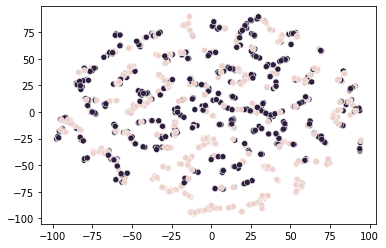

In [ ]:
#Plot results
import pandas as pd

import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=3).fit_transform(emb_patients)
X_embedded.shape

df = pd.DataFrame(X_embedded)
df['label'] = emb_labels
df = df.dropna()
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

g = sns.scatterplot(x=0, y=1, data=df, hue="label", legend=False)
g.set(xlabel=None)
g.set(ylabel=None)

plt.savefig('approach_private.pdf')